In [3]:
## imports
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import copy as cp
import pandas as pd
import countryinfo
import geopandas as gpd
from timeit import default_timer as timer # try to measure time
from climada.engine import Impact
from climada.entity import ImpactFunc,ImpactFuncSet
from os import mkdir, remove, rmdir



In [4]:
##function definition
from functions import *
from climada_functions import *
from constants import * 

In [5]:
print(cmip6vars)

{'sfcWindmax': 'SWM', 'sfcWind': 'SW', 'psl': 'SLP', 'tas': 'TAS', 'ua': 'UA', 'ta': 'TA', 'tos': 'TOS'}


In [6]:
## select data
#select variable (cmip6 naming)
selvar = 'sfcWindmax'
pathinvar = pathcmip6+'sfcWindmax/'

#preprocessing 
gst_fact = 1.67
qt = 0.98
cut=5E5
min_lat=30
max_lat=75
min_lon=-30
max_lon=30

##climada constants
haz_type = 'WS'
haz_id = 1

## naming
#name base (meteo) variable
metvar = [cmip6vars[selvar]]
spaceres = ["br_rg"] #base resolution regridded
timeres = ["day"]
domain = ["EU"]
season = ["winE"]
scen = ["allscens"]
sep = "_"
lst_bn = metvar+spaceres+timeres+domain+season
basenamemet = sep.join(lst_bn)

#preproc field
processings = ["qt"+str(qt)[-2:]+"pst","cutarea"+format(cut,'.0E').replace("+0",''),"gst1-67"]
basenamemet_proc = make_fn(processings,basenamemet)



# Exposure

In [7]:
##get country list
EU_countries = []
non_id = ["Vatican City", "Russia", "Republic of Ireland", "Macedonia"]
EU_countries = [ctr['name'] for ctr in countryinfo.countries if (ctr['continent'] == 'Europe' and ctr['name'] not in non_id)]

#for country in countryinfo.countries:
#    if (country['continent'] == 'Europe' and country['name'] not in non_id): 
#        EU_countries.append(country['name'])
        
#vatican city, Russia, Republic of Ireland, Macedonia: non identified
#try with modified names
add_list = ["Vatican City State","Ireland","Republic of Moldova","Kosovo","Macedonia"] #ignore "Russian Federation"
EU_countries = EU_countries + add_list

In [8]:
len(EU_countries)

45

In [9]:
## country groups v1
UK = ['United Kingdom','Ireland'] #remove iceland?
WEU = ['France','Kingdom of the Netherlands','Switzerland','Luxembourg','Belgium','Denmark','Germany',
       'Liechtenstein','Monaco'] #western Europe
SEU = ['Albania','Croatia','Bosnia and Herzegovina','Montenegro','Spain','Portugal','Italy','Malta',
       'Greece','San Marino','Andorra','Vatican City State']
NOR = ['Sweden','Finland','Norway','Estonia','Latvia','Lithuania']
#regions_list1 = [UK,WEU,SEU,NOR]
EU_countries_temp = EU_countries.copy()
EU_countries_temp.remove('Iceland')
EEU = [ctr for ctr in EU_countries_temp if ctr not in (UK + WEU + SEU +NOR)] # eastern Europe
regions1 = {'UK':UK, 'WEU':WEU, 'SEU':SEU , 'NOR':NOR, 'EEU':EEU }

## get region ids
ltpop_info = pd.read_csv('/home/lseverino/MT/metadata/LitPop_metadata_countries_v1_2.csv',sep=',')

In [8]:
EEU

['Austria',
 'Bulgaria',
 'Belarus',
 'Czech Republic',
 'Hungary',
 'Poland',
 'Romania',
 'Slovenia',
 'Slovakia',
 'Ukraine',
 'Moldova',
 'Serbia',
 'Republic of Moldova',
 'Kosovo',
 'Macedonia']

In [9]:
## country groups v2 (see Christensen 2007)
BI = ['United Kingdom','Ireland'] 
IP = ['Spain', 'Portugal','Andorra']
FR = ['France','Monaco']
MID = ['Kingdom of the Netherlands','Switzerland','Luxembourg','Belgium','Germany',
       'Liechtenstein']
SC = ['Denmark','Sweden','Finland','Norway','Estonia','Latvia','Lithuania']
MED = ['Italy','Albania','Bosnia and Herzegovina','Croatia','Montenegro','Malta','Greece','San Marino','Vatican City State',
      'Slovenia','Macedonia']
#regions_list2 = [BI,IP,FR,ME,MD,SC]
EU_countries_temp = EU_countries.copy()
EU_countries_temp.remove('Iceland')
EEU = [ctr for ctr in EU_countries_temp if ctr not in (BI+IP+FR+MID+SC+MED)] # eastern Europe
regions2 = {'BI':BI, 'IP':IP, 'FR':FR , 'MID':MID, 'SC':SC, 'MED':MED,'EEU':EEU }

## get region ids
ltpop_info = pd.read_csv('/home/lseverino/MT/metadata/LitPop_metadata_countries_v1_2.csv',sep=',')

In [18]:
## country groups v3 (adapated from Christensen 2007)
BI = ['United Kingdom','Ireland'] 
IP = ['Spain', 'Portugal','Andorra']
FR = ['France','Monaco']
WEU = ['Kingdom of the Netherlands','Switzerland','Luxembourg','Belgium','Germany',
       'Liechtenstein']
SC = ['Denmark','Sweden','Finland','Norway','Estonia','Latvia','Lithuania']
MED = ['Italy','Albania','Bosnia and Herzegovina','Croatia','Montenegro','Malta','Greece','San Marino','Vatican City State',
      'Slovenia','Macedonia','Bulgaria','Serbia','Kosovo','Romania']
#regions_list2 = [BI,IP,FR,ME,MD,SC]
EU_countries_temp = EU_countries.copy()
EU_countries_temp.remove('Iceland')
EEU = [ctr for ctr in EU_countries_temp if ctr not in (BI+IP+FR+WEU+SC+MED)] # eastern Europe
regions3 = {'BI':BI, 'IP':IP, 'FR':FR , 'WEU':WEU, 'SC':SC, 'MED':MED,'EEU':EEU }

## get region ids
ltpop_info = pd.read_csv('/home/lseverino/MT/metadata/LitPop_metadata_countries_v1_2.csv',sep=',')

In [11]:
EEU

['Austria',
 'Belarus',
 'Czech Republic',
 'Hungary',
 'Poland',
 'Slovakia',
 'Ukraine',
 'Moldova',
 'Republic of Moldova']

In [21]:
# Download exposure
from climada.entity import LitPop
from climada.entity import Exposures
try:
        exp = LitPop.from_countries(EU_countries,res_arcsec=600)
except FileExistsError as err:
    print("Reason for error: The GPW population data has not been downloaded, c.f. section 'Input data' above.")
    raise err
exp.check()
exp.plot_scatter()
print('\n Region IDs (`region_id`) in this exposure:')
print(exp.gdf.region_id.unique())

2022-11-04 08:59:30,546 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2022-11-04 08:59:30,662 - climada.util.finance - WARNING - No data available for country. Using non-financial wealth instead


/home/lseverino/climada_python/climada/entity/exposures/litpop/litpop.py:607: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for idx, polygon in enumerate(list(country_geometry)):
/home/lseverino/climada_python/climada/entity/exposures/litpop/litpop.py:607: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for idx, polygon in enumerate(list(country_geometry)):
/home/lseverino/climada_python/climada/entity/exposures/litpop/litpop.py:621: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  litpop_gdf = litpop_gdf.append(gdf_tmp)


2022-11-04 08:59:54,490 - climada.util.finance - WARNING - No data for country, using mean factor.
2022-11-04 08:59:54,728 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020


/home/lseverino/climada_python/climada/entity/exposures/litpop/litpop.py:607: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for idx, polygon in enumerate(list(country_geometry)):
/home/lseverino/climada_python/climada/entity/exposures/litpop/litpop.py:607: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for idx, polygon in enumerate(list(country_geometry)):
/home/lseverino/climada_python/climada/entity/exposures/litpop/litpop.py:621: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  litpop_gdf = litpop_gdf.append(gdf_tmp)


ReadTimeout: HTTPSConnectionPool(host='api.worldbank.org', port=443): Read timed out. (read timeout=30)

In [ ]:
# download data for Kosovo and Macedonia separately
id_list = [0, 807] #Kosovo, Macedonia
try:
        exp_MK = LitPop.from_countries(id_list,res_arcsec=600) # you can provide either single countries or a list of countries
except FileExistsError as err:
    print("Reason for error: The GPW population data has not been downloaded, c.f. section 'Input data' above.")
    raise err
exp_MK.check()
exp_MK.plot_scatter()

In [18]:
#import exposure data
from climada.entity import Exposures
from climada import CONFIG
results = CONFIG.local_data.save_dir.dir()
exp = Exposures.from_hdf5(results.joinpath(('exposures/exp_crpd_EU_600.h5')))
exp.check()


# Main calculation cell
1) iterate over the selected models
2) iterate over the selected impf
3) function call
    preprocess the fields
    compute impacts
    save


/home/lseverino/.conda/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/home/lseverino/.conda/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  return self._crs.to_proj4(version=version)
/home/lseverino/.conda/envs/climada_env/lib/python3.8/site-packages/pyproj/crs/crs.py:1256: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coo

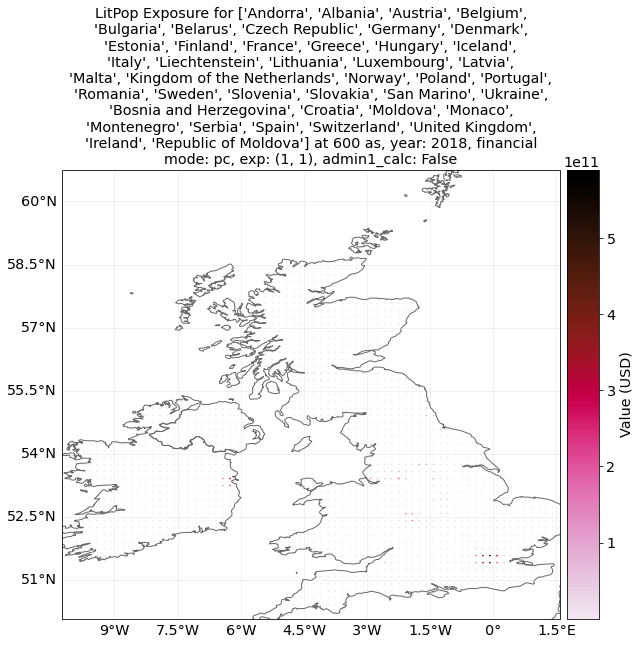

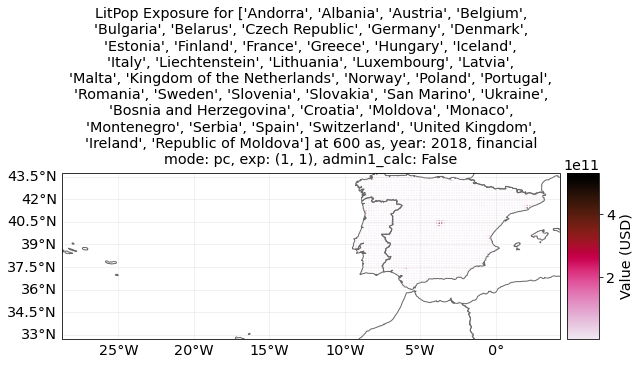

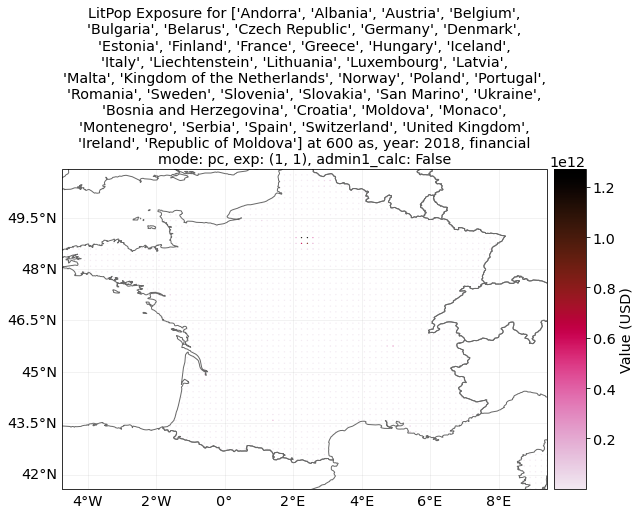

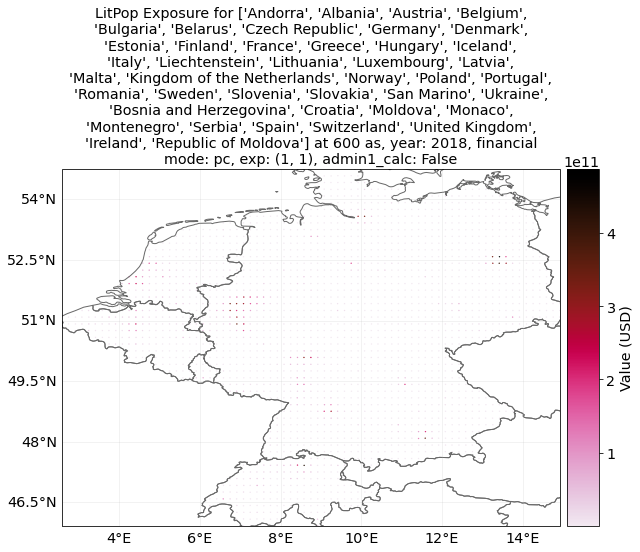

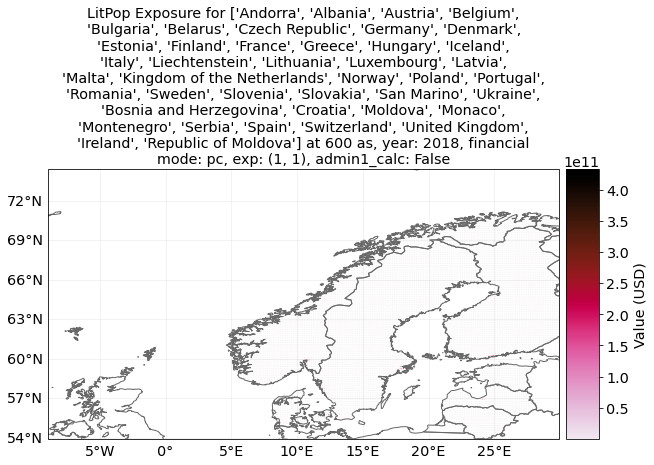

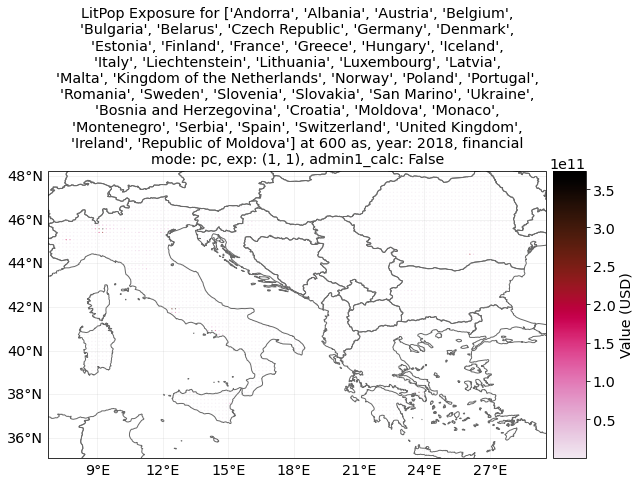

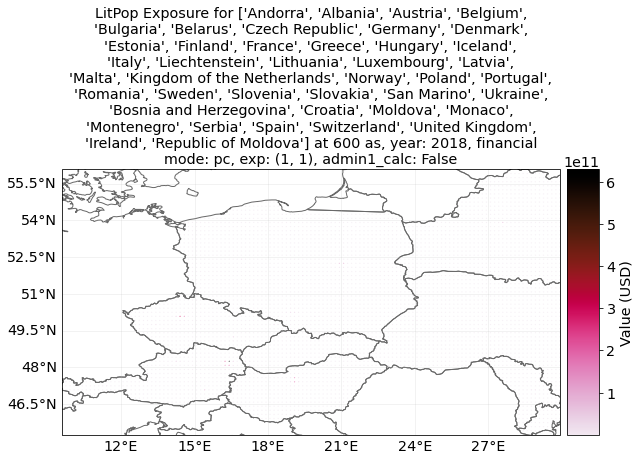

In [7]:
sel_reg = regions3
for reg in sel_reg.keys():
    
    #sel exposure according to region
    ctr_list = sel_reg[reg]
    reg_ids = ltpop_info['region_id'].where(ltpop_info['country_name'].isin(ctr_list)).dropna().tolist()
    if 'United Kingdom' in ctr_list: #manually add UK
        reg_ids.append(826)
    if 'Kingdom of the Netherlands' in ctr_list:
        reg_ids.append(528)
    if 'Austria' in ctr_list:
        reg_ids.append(40)
    if 'Moldova' in ctr_list:
        reg_ids.append(498)
    if 'Czech Republic' in ctr_list:
        reg_ids.append(203)
    if 'Macedonia' in ctr_list:
        reg_ids.append(807)
        
    sel_exp = cp.deepcopy(exp)
    sel_exp.gdf = sel_exp.gdf.where(sel_exp.gdf['region_id'].isin(reg_ids)).dropna()
    sel_exp.plot_hexbin(pop_name=False)

In [8]:
#load impfset
impf_set_uncal = ImpactFuncSet()
impf_set_uncal.read_excel(pathcal+"diff_impfset.csv")
pp_func_dic = pp_func_dic_diff
impf_dict = {}
impf_set_dict = {}
impf_namelist = []
for ifid, impf in impf_set_uncal.get_func()['WS'].items():
    impf_name = impf.name
    impf_namelist.append(impf_name)
    impf_dict[impf_name] = [ifid,impf]
    new_impfset = ImpactFuncSet()
    new_impf = cp.deepcopy(impf)
    new_impf.id = 0 
    new_impfset.append(new_impf)
    impf_set_dict[impf_name] = new_impfset


2022-08-15 12:57:20,353 - climada.entity.impact_funcs.impact_func_set - WARNING - The use of ImpactFuncSet.read_excel is deprecated.Use ImpactFuncSet.from_excel instead.
2022-08-15 12:57:20,878 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-08-15 12:57:20,879 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.
2022-08-15 12:57:20,880 - climada.entity.impact_funcs.impact_func_set - WARNING - Input ImpactFunc's id not set.


array([<AxesSubplot:title={'center':'WS 1: Cubic excess-over-threshold'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 2: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 3: Schwierz 2010'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>],
      dtype=object)

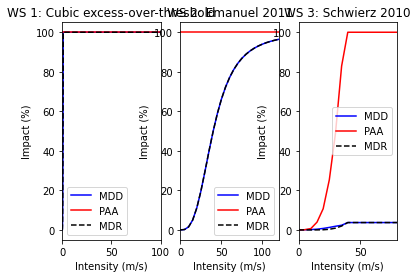

In [10]:
impf_set_uncal.plot()

In [14]:
impf_namelist

['Cubic excess-over-threshold', 'Emanuel 2011', 'Schwierz 2010']

In [15]:
scenlist

['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

In [34]:
#select vars
modlist = modlist_ssp585+modlist_allscen
impf_used = impf_namelist
scen_used= ['historical','ssp585']
#scen_used= scenlist
sel_reg = regions2 #select a region
pastname = 'historical'
timeres='day'
nmems = 3

In [35]:
#initiate df to save results
metrics = ["AAI_agg","15 yr impact","30 yr impact"]
itercol = [sel_reg,scen_used,impf_used,metrics]
col_idx = pd.MultiIndex.from_product(itercol,names=["region","scenario","impf","metric"])
iterrows = [modlist,range(nmems)]
row_idx= pd.MultiIndex.from_product(iterrows,names=["model","member"])

In [36]:
#select calibration file 
caltype = 'AAI_EMDAT_100mn'
bn_cal = basenamemet_proc+'_allmods'
calname = make_fn(["cal",caltype],bn_cal,filetype=".csv")

In [38]:
#main calculation cell. Select impact functions to use from the available impact function in impf_namelist. Enable calibration
#using calibration=True. Specify name to save the files with savename.
savehaz = False
saveimpmat = False
saveimpcsv = True
stack = True
if_id = 0
df_list = []
impf_keys = []

#initiate df
if stack:
    res_df = pd.DataFrame(columns=col_idx,index=modlist)
else:
    res_df = pd.DataFrame(columns=col_idx,index=row_idx)
    

for impf in impf_used:
    
    # get impfset
    impf_set = impf_set_dict[impf]
    
    # get names
    impf_namesht = impf_sht_names[impf]
    pp_funcname = str(pp_func_dic[impf]).split(" ")[1]
    
    for scen in scen_used:
        for modid, modname in enumerate(modlist):    
            #read netcdf
            fn = make_fn([modname],basenamemet,filetype=".nc")
            ncdf = xr.open_dataset(pathinvar+fn)
            ncdfw = ncdf[[pastname,scen]]
            latres, lonres = get_lat_lon_res(ncdf)
            #apply gust factor
            gust_ds = gst_fact*ncdfw
            #calibrate impf
            if caltype!='nocal':
                paramspath = pathcal+calname
                param = pd.read_csv(paramspath,header=[0],index_col=0).loc[modname,impf]
                impf_set = tune_impf(impf_set,param,modname,plot=False)
                if_id = 1 #select calibrated impf
                
            #select number of members to be considered
            if stack:
                nmems=1
            else:
                nmems = len(ncdf.member)

            #iterate over the members
            for imem in range(nmems):
                #preprocess fields
                if stack:
                    mem_da = gust_ds
                else: 
                    mem_da = gust_ds.sel(member=imem)
            
                preprocess_func = pp_func_dic[impf]
            
                gust_pp = preprocess_func(mem_da,qt,cutarea=cut,timeres=timeres,pastname=pastname,futname=scen,stack=stack)
                
                if scen != 'historical':
                    gust_pp_sel = gust_pp[scen]
                else:
                    gust_pp_sel = gust_pp
                
                #prepare hazards centroids
                haz = set_centroids(gust_pp_sel,stack=stack,timeres=timeres)
                if impf_namesht == 'CubEOT':
                    max_int =  haz.intensity.max()
                    if max_int >= 1:
                        print("*"*100+'\n\n'+' '*25+'/!\ max_int = '+str(max_int)+' for model '+modname+'\n\n'+"*"*100)
                
                for reg in sel_reg.keys():
                    #sel exposure according to region
                    ctr_list = sel_reg[reg]
                    reg_ids = ltpop_info['region_id'].where(ltpop_info['country_name'].isin(ctr_list)).dropna().tolist()
                    sel_exp = sel_reg_exp(reg_ids,ctr_list,exp)
                   
                    # Exposures: rename column and assign id
                    sel_exp.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
                    sel_exp.gdf['impf_' + haz_type] = if_id
                    
                    #assign centroids
                    dist_th = np.sqrt((latres*100)**2 + (lonres*100)**2)
                    sel_exp.assign_centroids(haz,distance='euclidean',threshold=dist_th)
                    sel_exp.check()

                    #compute impacts
                    print('Computing impact for region '+reg)
                    #past
                    start_time = timer()
                    imp = Impact()
                    imp.calc(sel_exp, impf_set, haz, save_mat=saveimpmat) #Do not save the results geographically resolved (only aggregate values)
                    time_delta_past = timer() - start_time
                    print(time_delta_past)
                    
                    #compute freq curves 
                    imp45 = imp.calc_freq_curve(return_per=15).impact 
                    imp90 = imp.calc_freq_curve(return_per=30).impact 
        
                    
                    #save results
                    if stack:
                        res_df.loc[modname,(reg,scen,impf,"AAI_agg")] = imp.aai_agg
                        res_df.loc[modname,(reg,scen,impf,"15 yr impact")] = imp45
                        res_df.loc[modname,(reg,scen,impf,"30 yr impact")] = imp90
                    else: 
                        res_df.loc[(modname,imem),(reg,scen,impf,"AAI_agg")] = imp.aai_agg
                        res_df.loc[(modname,imem),(reg,scen,impf,"15 yr impact")] = imp45
                        res_df.loc[(modname,imem),(reg,scen,impf,"30 yr impact")] = imp90
                
                    ##save files
                    
                    if stack:
                        simname = 'stacked'
                        savesubdir = 'stacked/'+reg+'/'+scen+'/'
                    else:
                        simname = 'nmem'+str(imem)
                        savesubdir = 'memsep/'+reg+'/'+scen+'/'
                        
                    ##save files
                    savenamehaz = make_fn(['haz',simname,reg,scen,modname,pp_funcname],basenamemet_proc,filetype='.h5')
                    
                    savenameimp = make_fn(['imp',simname,reg,scen,modname,impf_namesht,caltype,pp_funcname],basenamemet_proc)
                    
                    #save hazards
                    if savehaz:
                        try:
                            haz.write_hdf5(pathhaz+savesubdir+savenamehaz)
                        except FileNotFoundError:
                            mkdir(pathhaz+savesubdir)
                            haz.write_hdf5(pathhaz+savesubdir+savenamehaz)
                    #save impacts
                    if saveimpcsv:
                        try:
                            imp.write_csv(pathimp+'impact csv/regional/'+savesubdir+savenameimp+'.csv')
                        except FileNotFoundError:
                            mkdir(pathimp+'impact csv/regional/'+savesubdir)
                            imp.write_csv(pathimp+'impact csv/regional/'+savesubdir+savenameimp+'.csv')
                    if saveimpmat:
                        try:
                            imp.write_sparse_csr(pathimp+'impact matrices/regional/'+savesubdir+savenameimp+'.npz')
                        except FileNotFoundError:
                            mkdir(pathimp+'impact matrices/regional/'+savesubdir)
                            imp.write_sparse_csr(pathimp+'impact matrices/regional/'+savesubdir+savenameimp+'.npz')
                

    #res_df = res_df.astype(np.float64)
    #impf_keys.append(impf_namesht)
    #df_list.append(res_df)

res_df = res_df.astype(np.float64)
#res_df_all = pd.concat(df_list,keys=impf_keys,axis=1,names=("Impf","scenario","metric"))

Computing impact for region BI
0.017960887402296066
Computing impact for region IP
0.023922912776470184
Computing impact for region FR
0.025516722351312637
Computing impact for region MID
0.02399587258696556
Computing impact for region SC
0.09135901555418968
Computing impact for region MED
0.024617254734039307
Computing impact for region EEU
0.06492119655013084
****************************************************************************************************

                         /!\ max_int = 1.3647537472836784 for model BCC-CSM2-MR

****************************************************************************************************
Computing impact for region BI
0.0175650455057621
Computing impact for region IP
0.023597531020641327
Computing impact for region FR
0.023634720593690872
Computing impact for region MID
0.02273106575012207
Computing impact for region SC
0.08667825907468796
Computing impact for region MED
0.024818703532218933
Computing impact for region EEU
0.06194896